In [1]:
# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import StratifiedKFold
import statistics

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import *

In [2]:
plt.rcParams['font.size'] = '16'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '20'
legend_font = '16'
title_font = '24'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]
gray = '#8b96ad'
red = '#c74546'
dark = 'k'

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data and QC

In [3]:
tenx_bcs = pd.read_csv('/home/mffang/data/counts/10x/K562_flex_2022/sample_filtered_feature_bc_matrix/barcodes.tsv',sep='\t',header=None)
tenx_bcs

,0
0,AAACAAGCAATAGAGA-1
1,AAACAAGCAATGAGCC-1
2,AAACAAGCACTAACGA-1
3,AAACAAGCACTCAAAG-1
4,AAACAAGCAGCACGTG-1
...,...
11640,TTTGGCGGTTGTCCAG-1
11641,TTTGTGAGTACGGGCA-1
11642,TTTGTGAGTACGTTCG-1
11643,TTTGTGAGTCCAGCTA-1


In [4]:
tenx_bc = [ bc[:16]  for bc in tenx_bcs[0]]

In [5]:
rna = ad.read_h5ad('/home/mffang/data/counts/10x/K562_flex_2022/kb/counts_unfiltered/adata.h5ad')
rna

AnnData object with n_obs × n_vars = 684742 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [6]:
rna = rna[rna.obs_names.isin(tenx_bc)]
rna

View of AnnData object with n_obs × n_vars = 11645 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

/home/mffang/miniconda3/envs/python_3.12/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


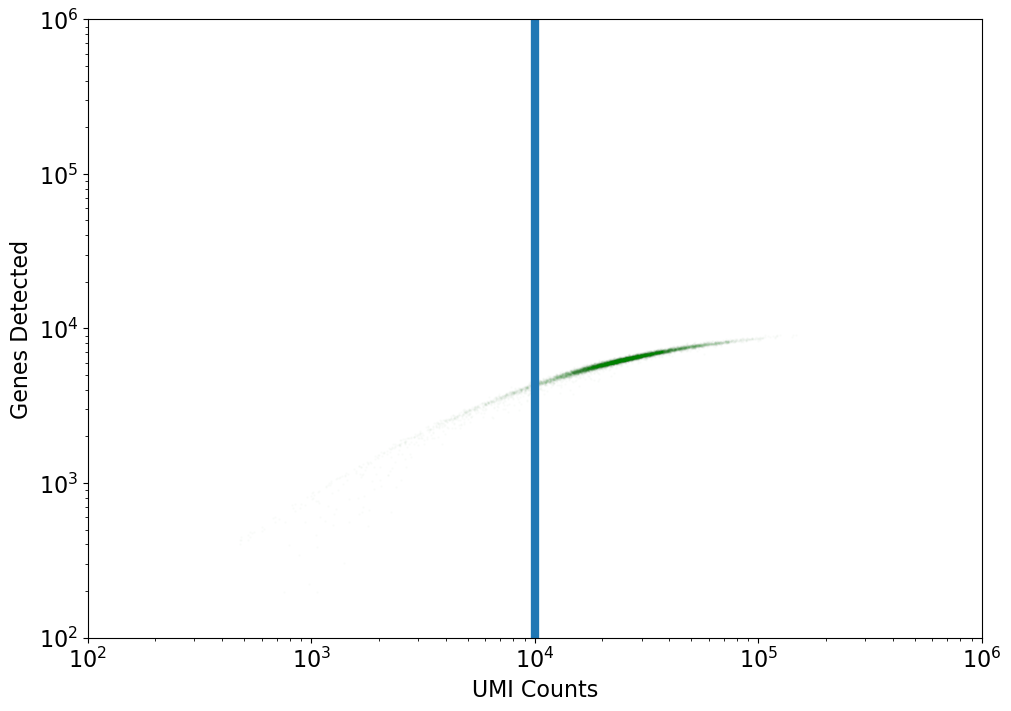

In [7]:
rna.X = rna.layers['ambiguous']+rna.layers['mature']+rna.layers['nascent']
mtx = rna.X

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", s=1, alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((1e2,1e6))
ax.set_ylim((1e2,1e6))
ax.axvline(x=10000)

plt.show()

In [8]:
import statistics

statistics.median(mtx.sum(axis=1))

matrix([[23727.]], dtype=float32)

In [9]:
adata = rna[mtx.sum(axis=1)>10000]
adata

View of AnnData object with n_obs × n_vars = 10778 × 39583
    layers: 'ambiguous', 'mature', 'nascent'

In [10]:
adata.layers['spliced'] = adata.layers['mature'] + adata.layers['ambiguous']

In [11]:
adata.var['gene_id'] = adata.var_names
adata.var_names = [g.split('.')[0] for g in adata.var_names]
adata.var

,gene_id
ENSG00000228037,ENSG00000228037.1
ENSG00000142611,ENSG00000142611.17
ENSG00000284616,ENSG00000284616.1
ENSG00000157911,ENSG00000157911.11
ENSG00000260972,ENSG00000260972.1
...,...
ENSG00000275063,ENSG00000275063.1
ENSG00000277856,ENSG00000277856.1
ENSG00000271254,ENSG00000271254.7
ENSG00000268674,ENSG00000268674.2


# Calculate CV$^2$ of read depth

0.00028142476 0.15911901 0.54156846


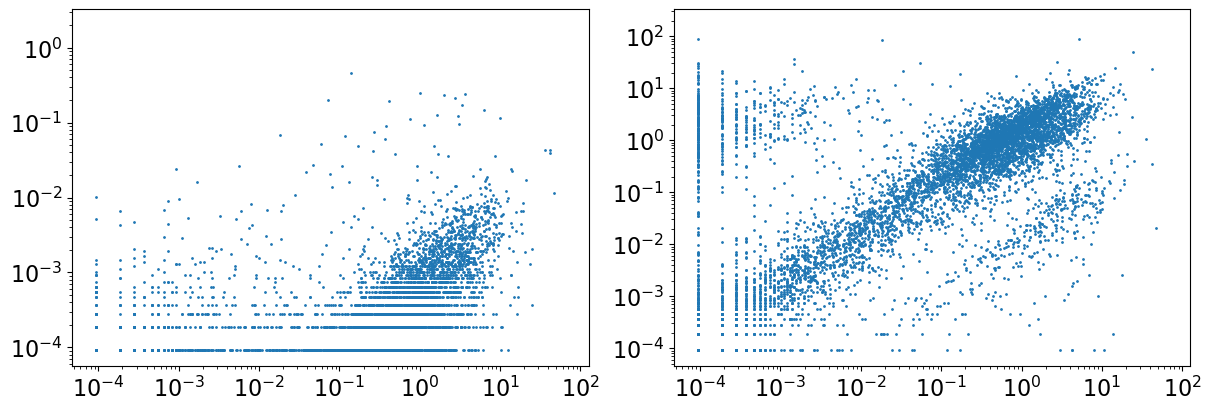

In [12]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['nascent'].toarray().mean(0),s=1)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].scatter(adata.layers['mature'].toarray().mean(0),adata.layers['ambiguous'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['nascent'].toarray().mean(),adata.layers['mature'].toarray().mean(),adata.layers['ambiguous'].toarray().mean())

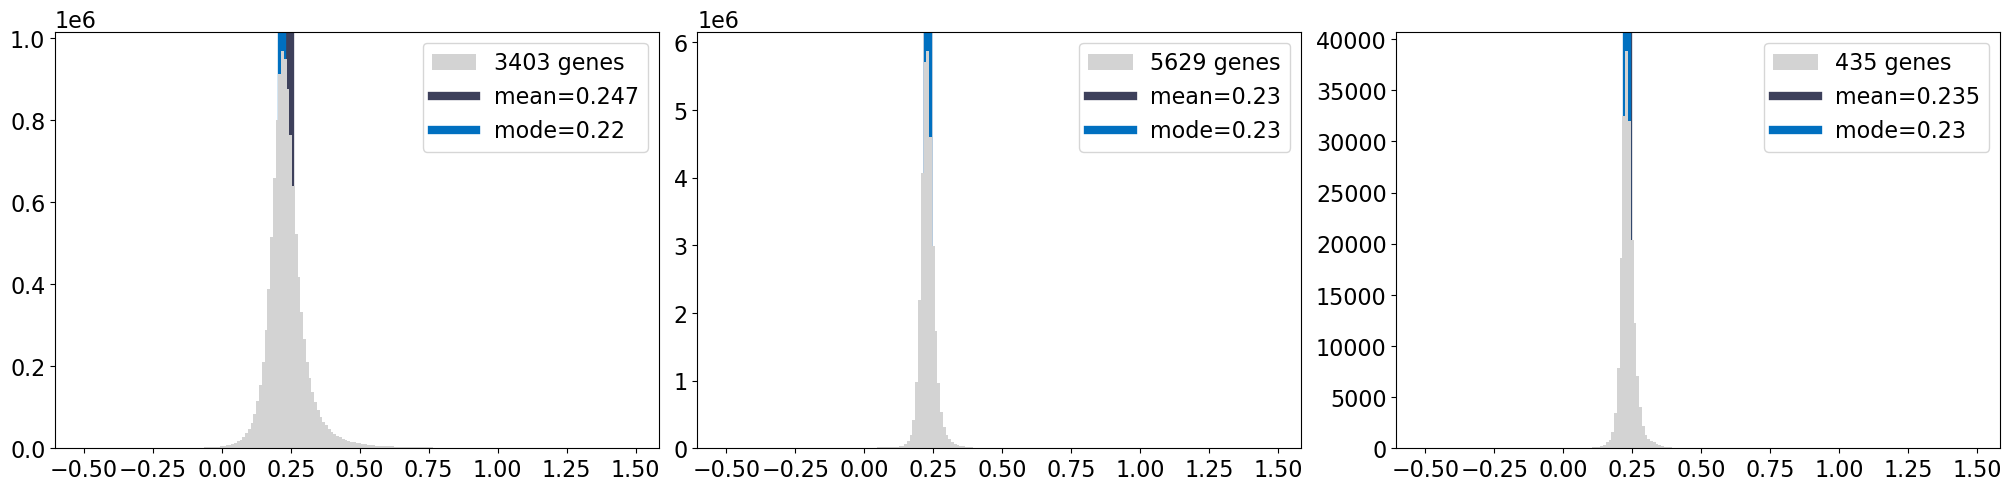

In [13]:
fig,axs = plt.subplots(1,3,figsize=(20,4.8))

s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["spliced"].toarray(),ax=axs[2],min_mean=10)

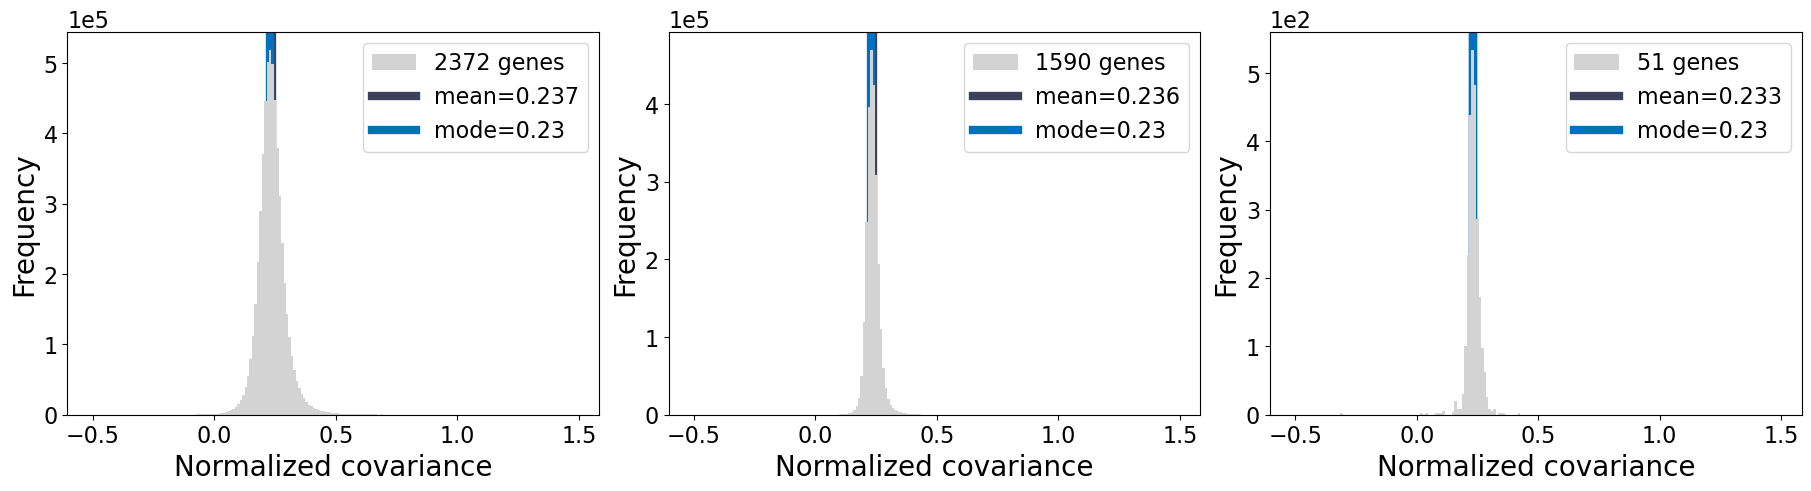

In [44]:
fig,axs = plt.subplots(1,3,figsize=(18,4.8))

s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["mature"].toarray(),ax=axs[2],min_mean=10)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

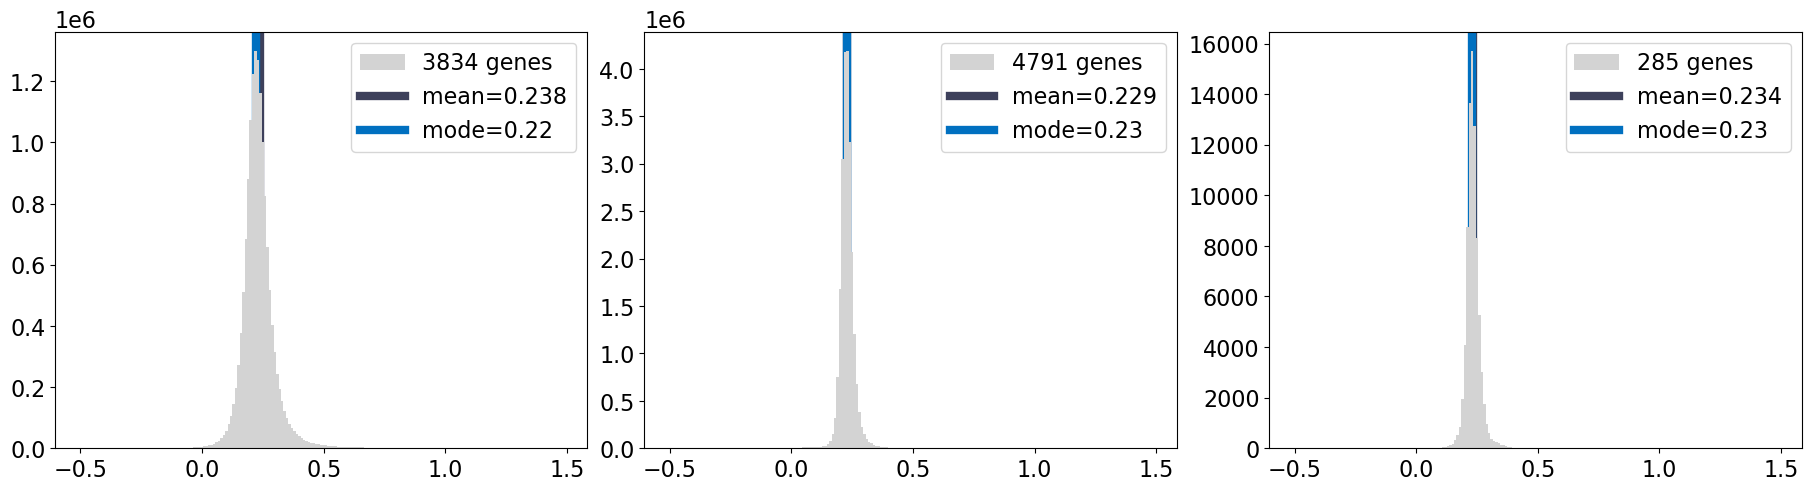

In [45]:
fig,axs = plt.subplots(1,3,figsize=(18,4.8))

s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[0],min_mean=0.1,max_mean=1)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[1],min_mean=1,max_mean=10)
s = estimate_s(N1=adata.layers["ambiguous"].toarray(),ax=axs[2],min_mean=10,max_mean=np.inf)

**It looks like that s remains consistent across genes with different means**

# Variance plots

In [25]:
adata.layers['mature'].toarray().sum(1).mean()/360000

0.01749562445746528

In [33]:
def overdispersion(sampled_datasets,idx,eps=0.):
    """
    This function computes the overdispersion for the sampled datasets. 
    The normalized variance is defined as:
    
        eta = (variance - mean) / mean^2 - eps / mean
    
    Parameters
    ----------
    sampled_datasets : list of ndarray
        A list of 2D arrays (datasets), where each dataset represents a set of samples with features.
        Each dataset should have shape `(n_samples, n_features)`.
    
    eps : float or 1D array, optional, default=0
        A small constant to adjust the normalized variance formula. It can be used to prevent division by zero or
        to apply a bias to the calculated residue.

    Returns
    -------
    s : list of ndarray
        A list containing the normalized variance for each dataset in `sampled_datasets`.
        Each entry in the list corresponds to a dataset and has shape `(n_features,)`.
    """
    
    np.random.seed(idx)
    assert len(sampled_datasets)==1
    n_samples = sampled_datasets[0].shape[0]
    b_idx = np.random.choice(a=n_samples,size=n_samples)
    X = sampled_datasets[0][b_idx]
    assert len(np.shape(X))==2, "sampled_datasets needs to be a list of 2D arrays"
    
    bootstrap_var = X.var(axis=0)
    bootstrap_mean = X.mean(0)

    # Calculate residue (normalized variance)
    eta = (bootstrap_var - bootstrap_mean) / bootstrap_mean**2 - eps / bootstrap_mean
    
    return np.array(eta)

In [34]:
X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]

lower_bound, upper_bound, eta_bootstrap = bootstrapping_func(overdispersion,[X_],B=1000,n_cores=50)

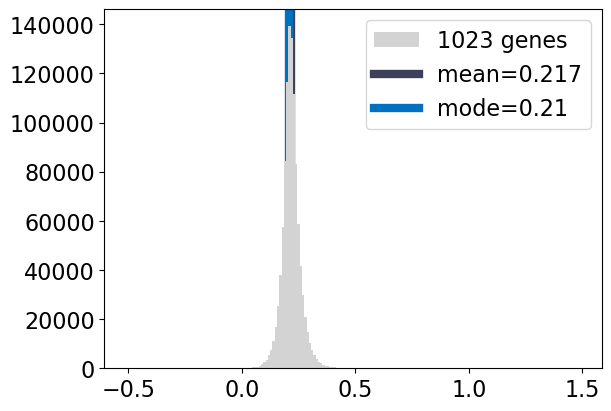

In [37]:
s = 0.23

S_Pgene_mask = (s < upper_bound) & (s > lower_bound) 
S_Pgene = adata.var_names[nonzero_idx][S_Pgene_mask]

fig,axs = plt.subplots(1,1,figsize=(6,4))

idx = adata.var_names.isin(S_Pgene)
X_S = adata.layers["mature"].toarray()[:,idx]
_ = estimate_s(X_S,ax=axs,min_mean=0.1)

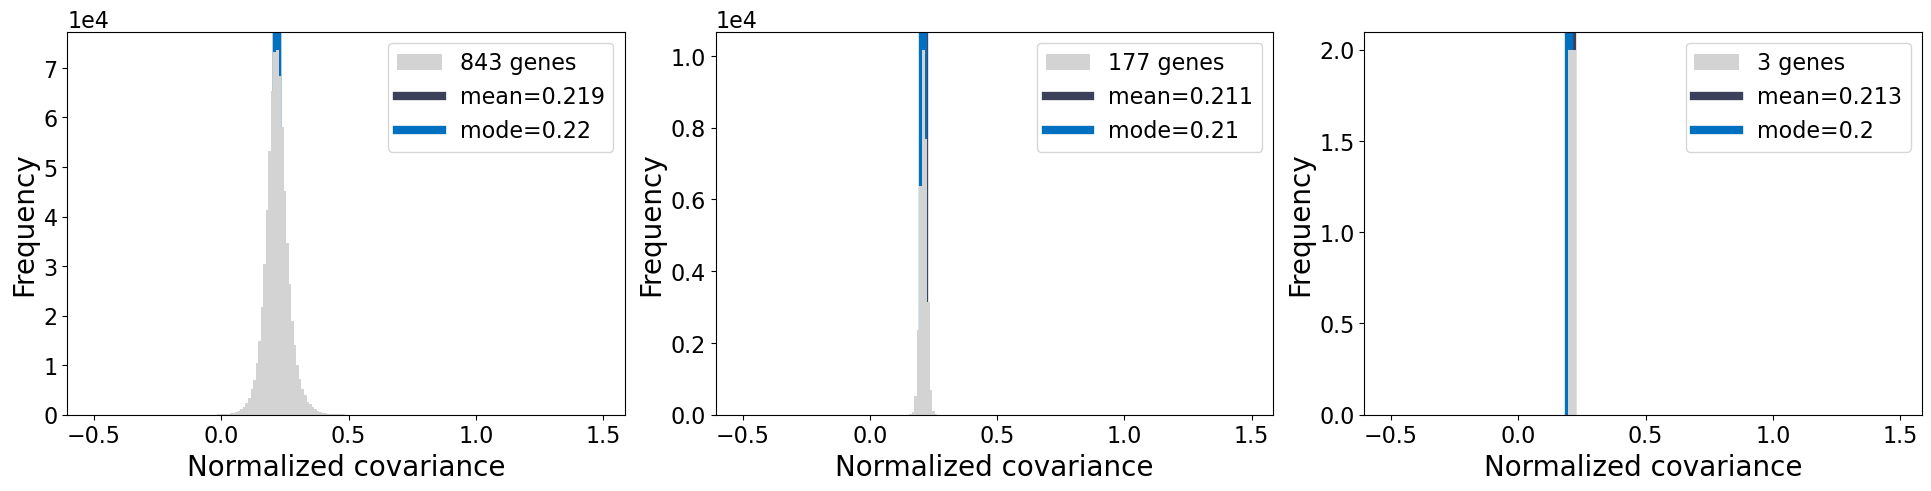

In [48]:
fig,axs = plt.subplots(1,3,figsize=(19.2,4.8))

_ = estimate_s(N1=X_S,ax=axs[0],min_mean=0.1,max_mean=1)
_ = estimate_s(N1=X_S,ax=axs[1],min_mean=1,max_mean=10)
_ = estimate_s(N1=X_S,ax=axs[2],min_mean=10)

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Normalized covariance',fontsize=20)
    axs[i].ticklabel_format(axis='y', style='sci', scilimits=(0, 0)) # scilimits=(0,0) to use scientific notation for all numbers

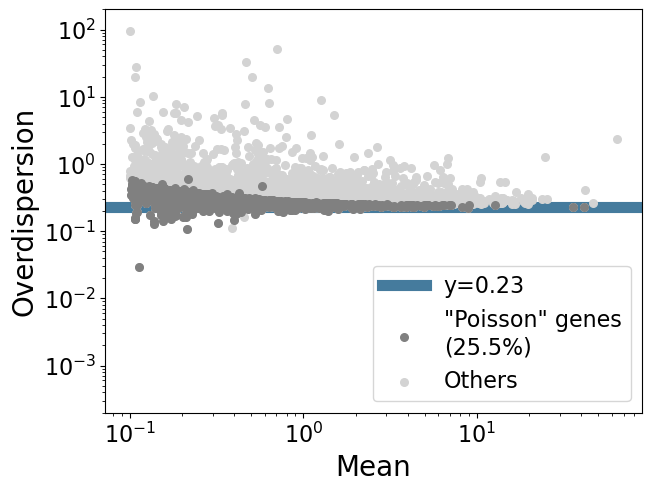

In [46]:
s = 0.23

X_ = adata.layers['mature'].toarray()
nonzero_idx = X_.mean(0)>0.1
X_ = X_[:,nonzero_idx]
X_var = X_.var(0)
X_mean = X_.mean(0)
Pgene_mask = S_Pgene_mask.copy()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.axhline(y=s, linestyle='-', color='#457b9d', linewidth=8, zorder=0, label="y="+str(np.around(s,3)))
ax.scatter(X_mean[Pgene_mask], (X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]**2, s=30, alpha=1, zorder=2, c='gray', \
           label='"Poisson" genes\n('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax.scatter(X_mean, (X_var-X_mean)/X_mean**2,c='lightgray',alpha=1, s=30, zorder=1, label='Others')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([2e-4,2e2])
ax.set_xlabel('Mean',fontsize=20);
ax.set_ylabel('Overdispersion',fontsize=20);
ax.legend(loc='lower right',fontsize=16);

r=0.99


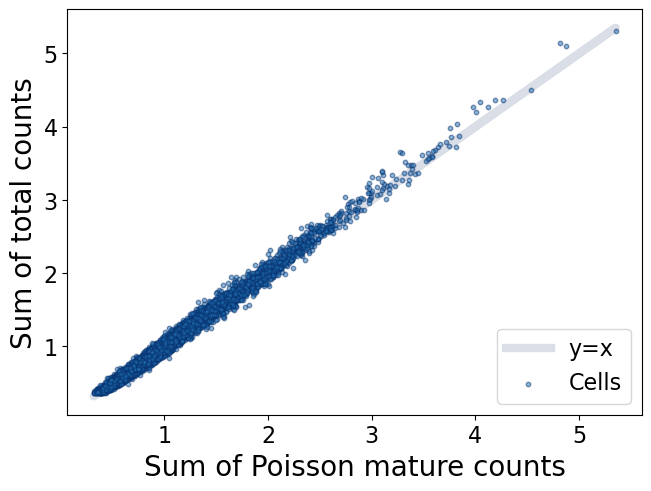

In [47]:
cellsize_S = X_S.sum(1)
cellsize_X = adata.X.toarray().copy().sum(1)

x = cellsize_S/cellsize_S.mean()
y = cellsize_X/cellsize_X.mean()

fig,ax = plt.subplots(1,1,figsize=(6.4,4.8))
ax.plot(x,x,zorder=0,color='#d9dee7',label='y=x')
ax.scatter(x,y,alpha=0.5,s=10,c='#2070b4',edgecolor='#08326e',label='Cells')
           
plt.legend(loc='lower right',fontsize=16)
plt.xlabel('Sum of Poisson mature counts',fontsize=20)
plt.ylabel('Sum of total counts',fontsize=20)
print('r='+str(np.around(np.corrcoef(x,y)[0,1],2)))

In [ ]:
# Save to text file (each string will be on a new line)
np.savetxt("results/K562_10x_Pgenes.txt", np.array(S_Pgene), fmt='%s')

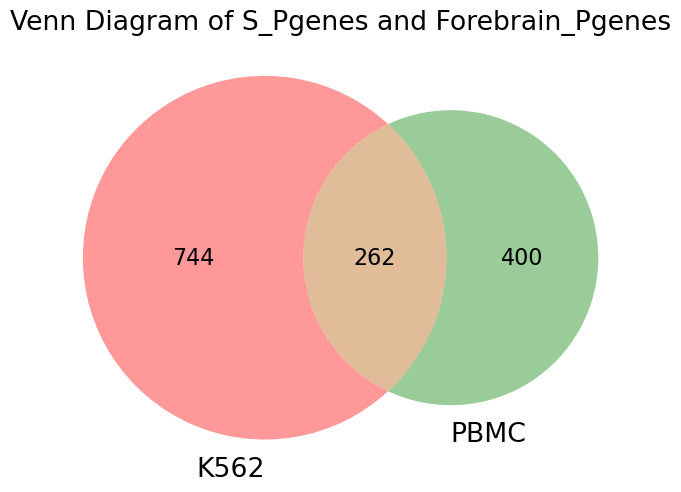

In [40]:
from matplotlib_venn import venn2

other_Pgenes = np.loadtxt("results/pbmc_Pgenes.txt", dtype=str)

# Convert to sets for Venn diagram
S_Pgene_set = set(S_Pgene)
other_Pgenes_set = set(other_Pgenes)

# Plot Venn diagram
plt.figure(figsize=(6,6))
venn2([S_Pgene_set, other_Pgenes_set], set_labels=('K562', 'PBMC'))

# Show the plot
#plt.title("Venn Diagram of S_Pgenes and Forebrain_Pgenes")
plt.show()

# Simulation

In [ ]:
c = cellsize_S/cellsize_S.mean()
lam = X_S.mean(0)
XX = np.random.poisson(c[:,None]*lam[None,:])

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12.8,4.8))

s_mm = estimate_s_(N1=X_S,ax=axs[0])
s_nn = estimate_s_(N1=XX,ax=axs[1])

for i in range(len(axs)):
    axs[i].set_ylabel('Frequency',fontsize=20)
    axs[i].set_xlabel('Values',fontsize=20)

# Check P genes

In [17]:
X_ = adata.layers["mature"].toarray()
nonzero_idx = X_.mean(0)>0.1
Pgenes = adata.var_names[nonzero_idx][S_Pgene_mask]

In [18]:
indrop_Pgenes = np.loadtxt('results/Indrop_K562_Pgenes.txt',dtype=str)

In [19]:
len(indrop_Pgenes),len(Pgenes),len(np.intersect1d(Pgenes,indrop_Pgenes))

(1211, 623, 59)

In [22]:
import gget

gget.enrichr(np.intersect1d(Pgenes,indrop_Pgenes),database='pathway',ensembl=True)

Wed Jul 31 08:05:00 2024 INFO Performing Enichr analysis using database KEGG_2021_Human. 
    Please note that there might be a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Wed Jul 31 08:05:00 2024 INFO Getting gene symbols from Ensembl IDs.
Wed Jul 31 08:15:11 2024 INFO Performing Enichr analysis on the following gene symbols: FIRRM, KMT2E, TFB1M, POLR1H, ROCK1, XRCC1, THOC1, AGBL5, EP300, POLE2, ATP13A1, SMC3, CCDC34, TIA1, CD46, IPO13, KMT2A, SET, ZC3H7A, DDX54, RALY, ERGIC3, ERMARD, PRKCSH, NOL11, ILKAP, PRMT7, FBH1, CARS2, AHI1, REV1, CCDC90B, ARL3, BRD4, EIF2D, C1orf131, PHIP, TRPT1, DHRS1, ALG8, LZIC, PBRM1, HNRNPK, NEMF, DNAJC21, CD2BP2, FEZ2, BPTF, PPP1CA, RNASEH2C, ANKRD13D, SRP72, PXMP2, HSPA14, MPHOSPH8, UCKL1, DYNLT2B, HEXA, CWC25


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,Base excision repair,0.004259,22.535371,123.012629,"[POLE2, XRCC1]",0.204663,KEGG_2021_Human
1,2,DNA replication,0.005053,20.543860,108.629590,"[RNASEH2C, POLE2]",0.204663,KEGG_2021_Human
2,3,Lysine degradation,0.014889,11.435145,48.109334,"[KMT2E, KMT2A]",0.338773,KEGG_2021_Human
3,4,Long-term potentiation,0.016730,10.729285,43.888984,"[EP300, PPP1CA]",0.338773,KEGG_2021_Human
4,5,cAMP signaling pathway,0.025941,4.961771,18.119987,"[ROCK1, EP300, PPP1CA]",0.380282,KEGG_2021_Human
...,...,...,...,...,...,...,...,...
76,77,Human cytomegalovirus infection,0.487516,1.517626,1.090311,[ROCK1],0.512842,KEGG_2021_Human
77,78,Shigellosis,0.518701,1.386066,0.909853,[ROCK1],0.538651,KEGG_2021_Human
78,79,Huntington disease,0.597881,1.110006,0.570947,[EP300],0.613017,KEGG_2021_Human
79,80,Human papillomavirus infection,0.626957,1.024608,0.478367,[EP300],0.634794,KEGG_2021_Human


In [72]:
U_genes = adata.var_names[adata.layers["ambiguous"].toarray().mean(0) > 0.1][~U_Pgene_mask]
S_genes = adata.var_names[adata.layers["mature"].toarray().mean(0) > 0.1][~S_Pgene_mask]
cov_genes = np.append(U_genes,S_genes)
cov_genes = U_genes[U_genes.isin(S_genes)]
len(U_genes),len(S_genes),U_genes.isin(S_genes).sum()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


(8464, 3390, 2813)

In [84]:
s = 0.23

idx = adata.var_names.isin(adata.var_names)

U = adata.layers["nascent"][:,idx].toarray()
S =  adata.layers["mature"][:,idx].toarray() 

idx = (U.mean(0)>0.1) & (S.mean(0)>0.1)
U = U[:,idx]
S = S[:,idx]

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(12,)

## Var(N_U)

Text(0.5, 1.0, '75.0% of cells >= 0')

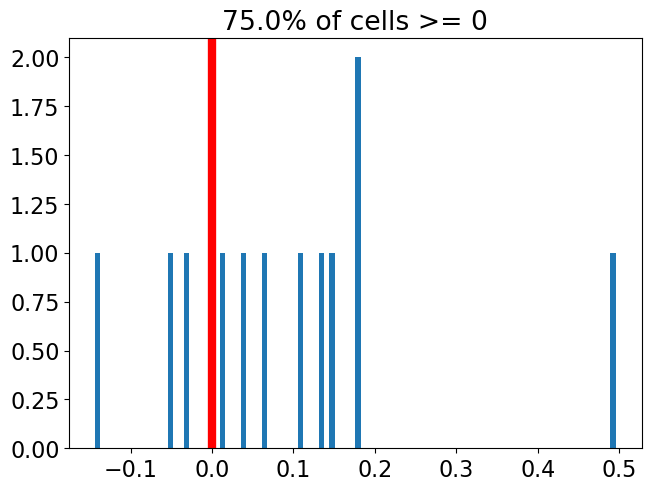

In [85]:
plt.hist(zeta_uu-s,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=s).mean(),2))+'% of cells >= 0')

## Cov(N_u,N_s)
$$\zeta_{us}<\zeta_{uu}$$

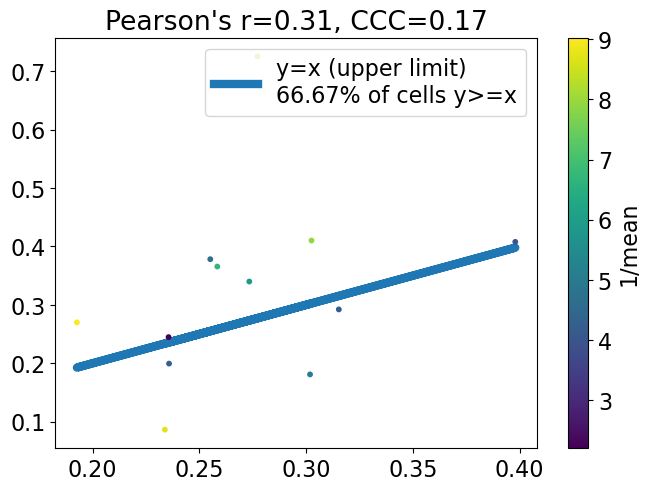

In [86]:
x=zeta_us
y=zeta_uu

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(y>=x).mean(),2))+'% of cells y>=x')
#plt.plot(x,2*x,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(y>=2*x).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## Var(N_s)

$$\zeta_{ss}=\zeta_{us}$$

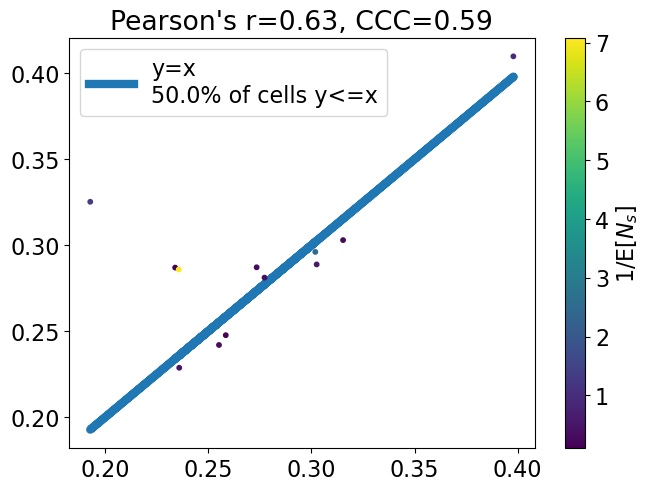

In [87]:
x=zeta_us
y=zeta_ss

plt.plot(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()